In [14]:
import torch
import torch.nn as nn
from pyhessian import hessian

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.fc(x)

# Initialize model, data, and loss function
model = SimpleModel()
criterion = nn.MSELoss()

# Example data
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
y = torch.tensor([[1.0], [0.0]])

# Compute loss
output = model(x)
loss = criterion(output, y)

# Compute the Hessian using pyhessian
hessian_comp = hessian(model, criterion, data=x, cuda=False)

# Access the full Hessian matrix
# full_hessian_matrix = hessian_comp.full_hessian

# Print the Hessian matrix
# print("Full Hessian matrix:")
# print(full_hessian_matrix)


d:\SDKs\miniconda3\envs\es335\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
dir(hessian_comp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'criterion',
 'data',
 'dataloader_hv_product',
 'density',
 'device',
 'eigenvalues',
 'full_dataset',
 'gradsH',
 'inputs',
 'model',
 'params',
 'targets',
 'trace']

In [16]:
hessian_comp.dataloader_hv_product([torch.tensor([1, 0, 0])])

IndexError: Dimension specified as 0 but tensor has no dimensions

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Compute Hessian
def compute_hessian(loss, params):
    grads = grad(loss, params, create_graph=True)
    grads_flat = torch.cat([g.view(-1) for g in grads])
    hessian = []
    
    for g in grads_flat:
        hess_row = grad(g, params, retain_graph=True)
        hess_row = torch.cat([hr.view(-1) for hr in hess_row])
        hessian.append(hess_row)

    return torch.stack(hessian)

# Training settings
input_size = 10
hidden_size = 8
output_size = 1
batch_size = 32
num_steps = 1000
hessian_checkpoints = [0.01, 0.5, 1.0]  # Training stages as fractions of num_steps

# Generate synthetic data
torch.manual_seed(42)
X = torch.rand(1000, input_size)
y = torch.rand(1000, output_size)

# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model and compute Hessians
step_hessians = {}
for step in range(num_steps):
    # Select batch
    idx = torch.randint(0, X.size(0), (batch_size,))
    X_batch, y_batch = X[idx], y[idx]
    
    # Forward pass
    predictions = model(X_batch)
    loss = criterion(predictions, y_batch)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    # Check for Hessian computation at specific steps
    for checkpoint in hessian_checkpoints:
        if step == int(checkpoint * num_steps):
            print(f"Computing Hessian at {int(checkpoint * 100)}% of training...")
            hessian = compute_hessian(loss, model.parameters())
            step_hessians[f"{int(checkpoint * 100)}%"] = hessian

# Print Hessian results (or save them for later analysis)
for stage, hess in step_hessians.items():
    print(f"Hessian at {stage} training: {hess.size()}")


Computing Hessian at 1% of training...


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [8, 1]], which is output 0 of AsStridedBackward0, is at version 12; expected version 11 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

Computing Hessian at epoch 10 (1.0%)
Computing Hessian at epoch 500 (50.0%)
Computing Hessian at epoch 1000 (100.0%)


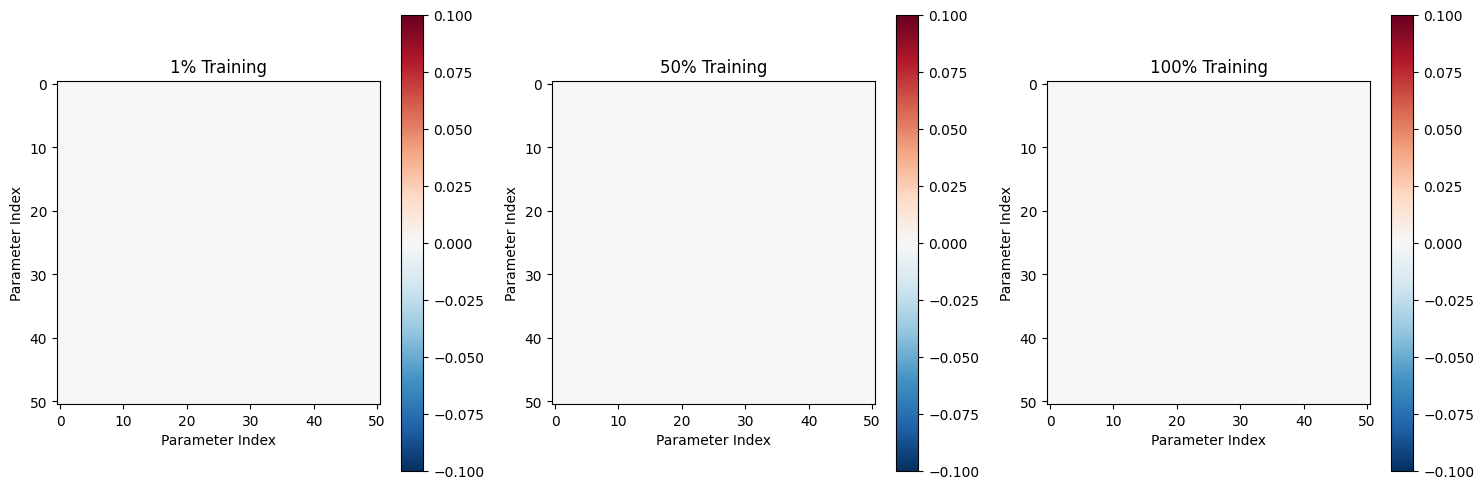


Statistics for 1% Training:
Mean value: 0.000000
Max value: 0.000000
Min value: 0.000000
Condition number: inf

Statistics for 50% Training:
Mean value: 0.000000
Max value: 0.000000
Min value: 0.000000
Condition number: inf

Statistics for 100% Training:
Mean value: 0.000000
Max value: 0.000000
Min value: 0.000000
Condition number: inf


In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from torch.autograd.functional import hessian
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate spiral dataset
def generate_spiral_data(samples_per_class=100, num_classes=3):
    X = np.zeros((samples_per_class * num_classes, 2))
    y = np.zeros(samples_per_class * num_classes, dtype=int)
    
    for class_idx in range(num_classes):
        ix = range(samples_per_class * class_idx, samples_per_class * (class_idx + 1))
        r = np.linspace(0.0, 1, samples_per_class)
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, samples_per_class) + np.random.randn(samples_per_class) * 0.2
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = class_idx
    
    return torch.FloatTensor(X), torch.LongTensor(y)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=8, output_size=3):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

# Function to compute Hessian matrix
def compute_hessian(model, loss_fn, inputs, targets):
    def loss_closure(params):
        # Reconstruct the model parameters
        start = 0
        for p in model.parameters():
            param_length = p.numel()
            p.data = params[start:start + param_length].view_as(p)
            start += param_length
            
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        return loss
    
    # Get the initial parameters
    params = torch.cat([p.view(-1) for p in model.parameters()])
    return hessian(loss_closure, params)

# Generate data
X, y = generate_spiral_data()

# Create model and define training parameters
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000
checkpoints = [int(0.01 * num_epochs), int(0.5 * num_epochs), num_epochs]  # 1%, 50%, 100%

# Training loop with Hessian computation at checkpoints
hessians = []
for epoch in range(1, num_epochs + 1):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch in checkpoints:
        print(f"Computing Hessian at epoch {epoch} ({epoch/num_epochs*100:.1f}%)")
        hessian_matrix = compute_hessian(model, criterion, X, y)
        hessians.append(hessian_matrix.detach().numpy())

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['1% Training', '50% Training', '100% Training']

for idx, (hessian_matrix, title) in enumerate(zip(hessians, titles)):
    im = axes[idx].imshow(hessian_matrix, cmap='RdBu_r')
    axes[idx].set_title(title)
    plt.colorbar(im, ax=axes[idx])
    axes[idx].set_xlabel('Parameter Index')
    axes[idx].set_ylabel('Parameter Index')

plt.tight_layout()
plt.show()

# Print some statistics about the Hessians
for idx, (hessian_matrix, title) in enumerate(zip(hessians, titles)):
    print(f"\nStatistics for {title}:")
    print(f"Mean value: {np.mean(hessian_matrix):.6f}")
    print(f"Max value: {np.max(hessian_matrix):.6f}")
    print(f"Min value: {np.min(hessian_matrix):.6f}")
    print(f"Condition number: {np.linalg.cond(hessian_matrix):.2f}")

Starting training...

Epoch 1 (1.0%)
Training loss: 1.1021

Epoch 50 (50.0%)
Training loss: 1.0570

Epoch 100 (100.0%)
Training loss: 1.0404

Statistics for 1% Training:
Mean value: 0.000000
Max value: 0.000000
Min value: 0.000000
Frobenius norm: 0.000000

Statistics for 50% Training:
Mean value: 0.000000
Max value: 0.000000
Min value: 0.000000
Frobenius norm: 0.000000

Statistics for 100% Training:
Mean value: 0.000000
Max value: 0.000000
Min value: 0.000000
Frobenius norm: 0.000000


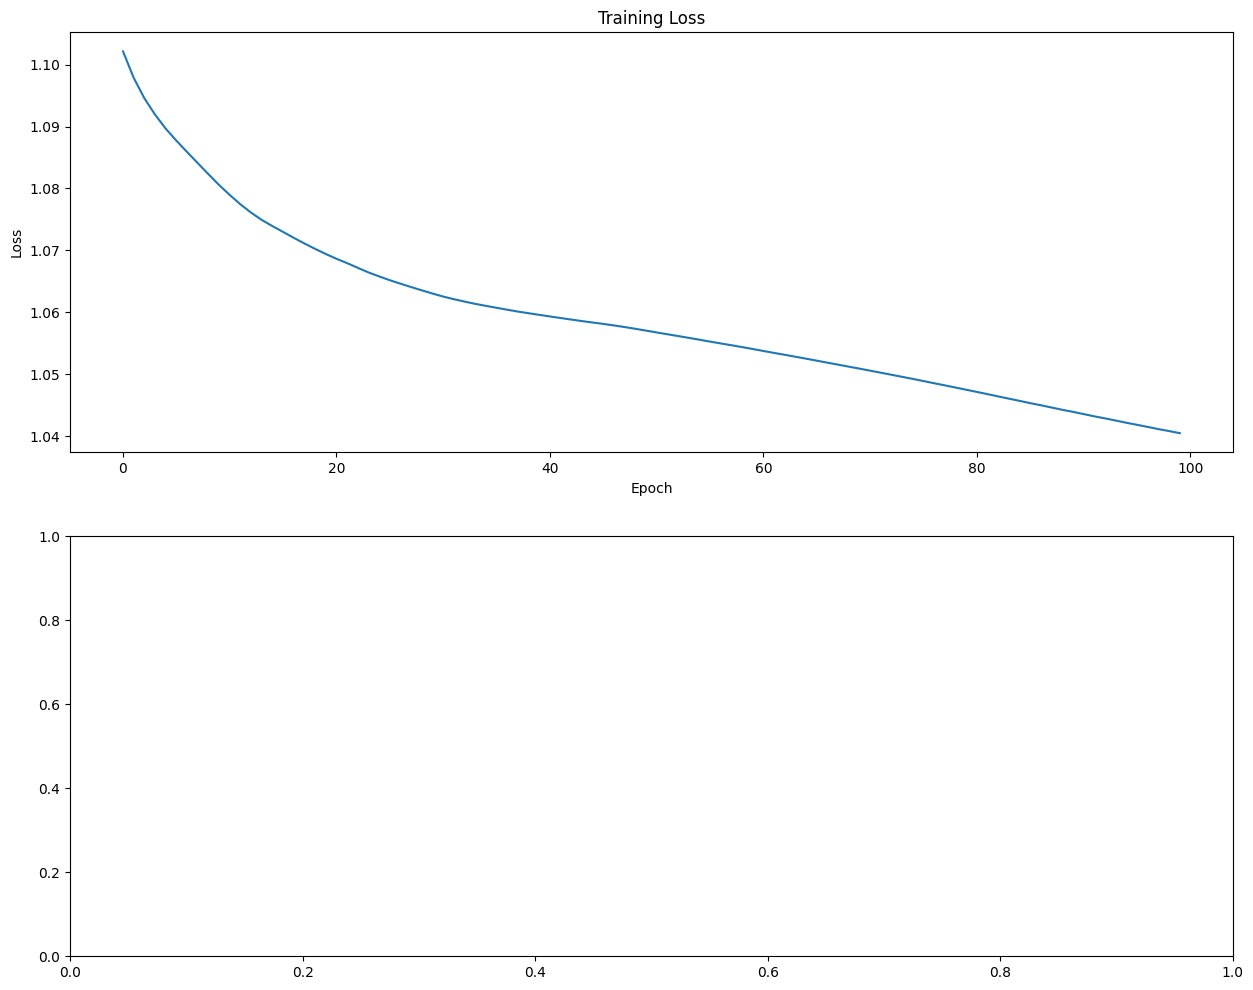

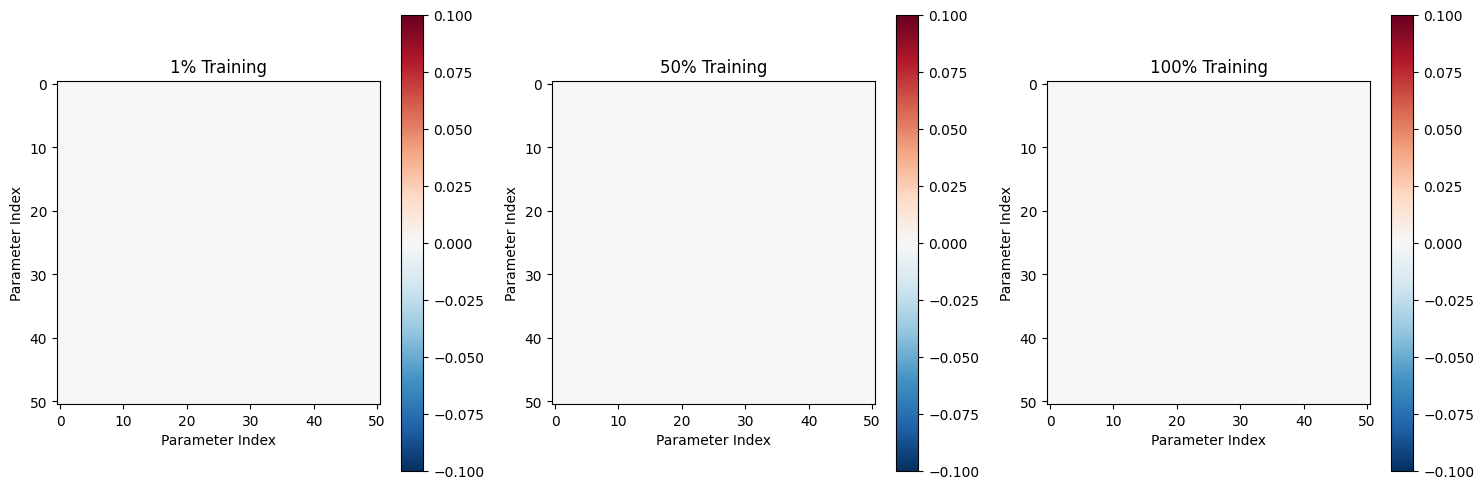

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd.functional import hessian
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate spiral dataset
def generate_spiral_data(samples_per_class=100, num_classes=3):
    X = np.zeros((samples_per_class * num_classes, 2))
    y = np.zeros(samples_per_class * num_classes, dtype=int)
    
    for class_idx in range(num_classes):
        ix = range(samples_per_class * class_idx, samples_per_class * (class_idx + 1))
        r = np.linspace(0.0, 1, samples_per_class)
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, samples_per_class) + np.random.randn(samples_per_class) * 0.2
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = class_idx
    
    return torch.FloatTensor(X), torch.LongTensor(y)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=8, output_size=3):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        
        # Initialize weights to avoid zero gradients
        nn.init.xavier_uniform_(self.layer1.weight)
        nn.init.xavier_uniform_(self.layer2.weight)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

def compute_hessian_sample(model, criterion, x_sample, y_sample):
    """Compute Hessian for a single sample"""
    def closure(flat_params):
        # Reshape flat parameters back into model parameters
        offset = 0
        for param in model.parameters():
            param_shape = param.shape
            param_size = param.numel()
            param.data = flat_params[offset:offset + param_size].reshape(param_shape)
            offset += param_size
            
        output = model(x_sample.unsqueeze(0))
        loss = criterion(output, y_sample.unsqueeze(0))
        return loss

    # Get flat parameters
    flat_params = torch.cat([p.view(-1) for p in model.parameters()])
    
    # Compute Hessian
    H = hessian(closure, flat_params)
    return H

# Generate smaller dataset for testing
X, y = generate_spiral_data(samples_per_class=50)  # Reduced sample size

# Create model and define training parameters
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100  # Reduced epochs for testing
checkpoints = [int(0.01 * num_epochs), int(0.5 * num_epochs), num_epochs]

# Training loop with Hessian computation at checkpoints
hessians = []
train_losses = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    train_losses.append(loss.item())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch in checkpoints:
        print(f"\nEpoch {epoch} ({epoch/num_epochs*100:.1f}%)")
        print(f"Training loss: {loss.item():.4f}")
        
        # Compute Hessian for a subset of data
        sample_idx = np.random.choice(len(X), size=5)  # Use 5 random samples
        batch_hessian = None
        
        for idx in sample_idx:
            H = compute_hessian_sample(model, criterion, X[idx], y[idx])
            if batch_hessian is None:
                batch_hessian = H
            else:
                batch_hessian += H
        
        batch_hessian /= len(sample_idx)  # Average the Hessians
        
        # Verify Hessian is not zero
        if torch.all(batch_hessian == 0):
            print("Warning: Hessian is zero! Something is wrong.")
        else:
            print(f"Hessian computed successfully. Max abs value: {torch.max(torch.abs(batch_hessian)).item():.6f}")
        
        hessians.append(batch_hessian.detach().numpy())

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot training loss
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot Hessians
titles = ['1% Training', '50% Training', '100% Training']
fig2, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (hessian_matrix, title) in enumerate(zip(hessians, titles)):
    im = axes[idx].imshow(hessian_matrix, cmap='RdBu_r')
    axes[idx].set_title(title)
    plt.colorbar(im, ax=axes[idx])
    axes[idx].set_xlabel('Parameter Index')
    axes[idx].set_ylabel('Parameter Index')
    
    # Print statistics
    print(f"\nStatistics for {title}:")
    print(f"Mean value: {np.mean(hessian_matrix):.6f}")
    print(f"Max value: {np.max(hessian_matrix):.6f}")
    print(f"Min value: {np.min(hessian_matrix):.6f}")
    print(f"Frobenius norm: {np.linalg.norm(hessian_matrix):.6f}")

plt.tight_layout()
plt.show()

In [23]:
import torch
import torchvision
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# Define the CNN model
class SimpleCNN(nn.Module):
	def __init__(self):
		super(SimpleCNN, self).__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, 10)
		self.relu = nn.ReLU()
		self.dropout = nn.Dropout(0.25)

	def forward(self, x):
		x = self.pool(self.relu(self.conv1(x)))
		x = self.pool(self.relu(self.conv2(x)))
		x = x.view(-1, 64 * 7 * 7)
		x = self.relu(self.fc1(x))
		x = self.dropout(x)
		x = self.fc2(x)
		return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0
	for images, labels in train_loader:
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
	
	print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
	for images, labels in test_loader:
		outputs = model(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%")

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



100%|██████████| 9.91M/9.91M [00:14<00:00, 705kB/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



100%|██████████| 28.9k/28.9k [00:00<00:00, 139kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.13MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch [1/5], Loss: 0.1948
Epoch [2/5], Loss: 0.0613
Epoch [3/5], Loss: 0.0437
Epoch [4/5], Loss: 0.0356
Epoch [5/5], Loss: 0.0277
Accuracy of the model on the 10000 test images: 99.16%


In [27]:
from PyHessian.pyhessian import hessian

# Compute the Hessian of the model
images.shape, labels.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [28]:
hessian_comp = hessian(model, criterion, data=(images, labels), cuda=False)

In [29]:
density_eigen, density_weight = hessian_comp.density()


In [31]:
#*
# @file Different utility functions
# Copyright (c) Zhewei Yao, Amir Gholami
# All rights reserved.
# This file is part of PyHessian library.
#
# PyHessian is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# PyHessian is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with PyHessian.  If not, see <http://www.gnu.org/licenses/>.
#*

import math
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt


def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.tight_layout()
    plt.savefig('example11.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)


In [32]:
get_esd_plot(density_eigen, density_weight)


C:\Users\DELL\AppData\Local\Temp\ipykernel_5172\2438156880.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])
